In [1]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# load train image database
!cp '/content/drive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project/train_images.zip' '/content'
!unzip 'train_images.zip' &> /dev/null

In [3]:
#Load the inverted Index 
import pickle
  
# Open the file in binary mode
with open('/content/drive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project/clustering_index.pkl', 'rb') as file:
    # Call load method to deserialze
    index = pickle.load(file)

In [4]:
# import other libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras.datasets import cifar100
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from scipy.spatial.distance import cosine

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [6]:
# parameters for data
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
n_classes = 100
batch_size =64

In [7]:
# load efficientnet architecture for extracting embeddings of query images
!pip install -U efficientnet &> /dev/n_ull


# code to get embedding of the query image goes here

import efficientnet.keras as efn 

efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, classes = 100, input_shape = input_shape)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation = 'softmax'))

# load pretrained weights
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project/best_weight.h5')

# build encoder model from efficientnet
from keras import models
newModel = models.Model(inputs =  model.inputs, outputs = model.layers[1].output)


16804768/16804768 [==============================] - 0s 0us/step


Enter the query image number: 47


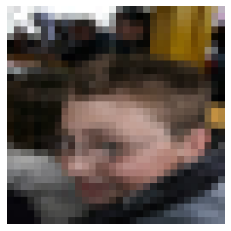

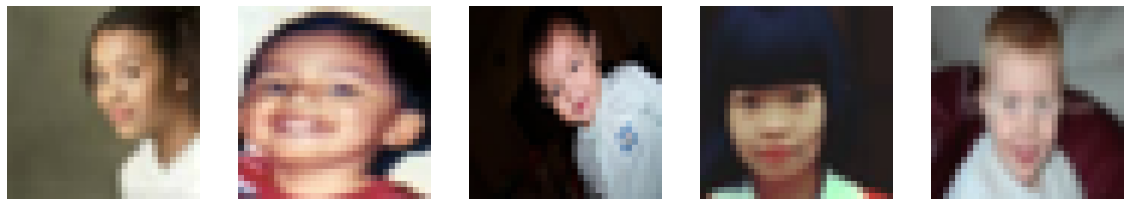


Time taken : 0.4970 seconds


In [13]:
# ask the user for the query image and get its embedding
query_img = input("Enter the query image number: ")
query_img_path = 'train_images/image'+str(query_img)+'.png' 
query_img = image.load_img(query_img_path, target_size=(224, 224))

# record start time
start  = time.time()

# preprocess the query image and get its embedding using the EfficientNet model
query_img = image.img_to_array(query_img)
query_img /= 255
query_img = np.expand_dims(query_img, axis=0)
query_embedding = newModel(query_img)



# compute the Euclidean distances between the query embedding and all the embeddings in the inverted index
distances = []
for i in range(len(index)):
  distances.append(cosine(query_embedding.reshape(-1),index[i][0].reshape(-1)))

# # find the closest term
closest_term = np.argmin(distances)

# get the posting list for the closest term and compute the distances between the query embedding and the embeddings in the posting list
posting_list = index[closest_term][1]
posting_distances = []
for posting in posting_list:
    dist = np.linalg.norm(posting[1] - query_embedding)
    posting_distances.append((posting[0], dist))

# # sort the posting list in ascending order of the distances to the query embedding
posting_distances.sort(key=lambda x: x[1])

# return the 5 closest images
posting_distances = posting_distances[:5]
closest_images = []
for id,dist in posting_distances:
  path = 'train_images/image'+str(int(id))+'.png'
  closest_images.append(image.load_img(path, target_size=(224, 224)))

# record end time
end = time.time()

# print query image
plt.imshow(query_img[0])
plt.axis('off')

# print relevant images
plt.figure(figsize=(20,4))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(closest_images[i])
  plt.axis('off')

plt.show()
print('\nTime taken : {:.4f} seconds'.format(end-start))